Use this notebook to train a transformer model
-------------------

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import mediapipe as mp

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image.flgs.writeable = False
    results = model.process(image)
    #image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections


In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    '''mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) '''
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [11]:
# DATA_PATH: path for exported data, numpy arrays - download the MP_Data folder with the Numpy array files (.npy) to local

DATA_PATH = "C:\\Users\\amrit\\OneDrive\\Documents\\PES University\\Sem-7\\Capstone\\dataset\\MP_Data"

# Actions that we try to detect
actions = np.array(['left_swipe', 'right_swipe', 'stop', 'thumbs_down', 'thumbs_up'])

# 139 videos worth of data
no_sequences = 139

# Videos are going to be 30 frames in length
sequence_length = 30

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [9]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'left_swipe': 0,
 'right_swipe': 1,
 'stop': 2,
 'thumbs_down': 3,
 'thumbs_up': 4}

In [12]:
# this step will take some time to run

sequences, labels = [], []
for action in actions:
    print(action)
    for sequence in range(1, no_sequences+1):
        print(sequence)
        window = []
        for frame_num in range(1, sequence_length+1):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

left_swipe
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
right_swipe
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
stop
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
2

In [42]:
print(np.array(sequences).shape)
print(np.array(labels).shape)

(695, 30, 1662)
(695,)


In [43]:
X = np.array(sequences)
X.shape

(695, 30, 1662)

In [44]:
y = to_categorical(labels).astype(int)

In [45]:
# to experiment train-test split sizes, change the test_size parameter value. Given below is 80-20 split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [47]:
y_train.shape

(556, 5)

In [62]:
y_test.shape

(139, 5)

In [48]:
from backbone import *

In [49]:
CHANNELS

1662

In [50]:
model = get_model()

In [51]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
history = model.fit(
    X_train,  # Your training data
    y_train,  # Your training labels (one-hot encoded or integer labels)
    validation_data=(X_test, y_test),  # Your validation data and labels
    epochs=50,  # Number of training epochs
    #batch_size=BATCH_SIZE,  # Batch size
)

Epoch 1/50
18/18 [==============================] - 45s 1s/step - loss: 4.3888 - accuracy: 0.4191 - val_loss: 5.6797 - val_accuracy: 0.1871
Epoch 2/50
18/18 [==============================] - 17s 925ms/step - loss: 4.0860 - accuracy: 0.4353 - val_loss: 2.3409 - val_accuracy: 0.3237
Epoch 3/50
18/18 [==============================] - 16s 905ms/step - loss: 3.1387 - accuracy: 0.5252 - val_loss: 1.2035 - val_accuracy: 0.6187
Epoch 4/50
18/18 [==============================] - 16s 900ms/step - loss: 2.9635 - accuracy: 0.5701 - val_loss: 3.1744 - val_accuracy: 0.4388
Epoch 5/50
18/18 [==============================] - 16s 902ms/step - loss: 2.7730 - accuracy: 0.5683 - val_loss: 4.2552 - val_accuracy: 0.4964
Epoch 6/50
18/18 [==============================] - 17s 930ms/step - loss: 2.3378 - accuracy: 0.6709 - val_loss: 1.9947 - val_accuracy: 0.5755
Epoch 7/50
18/18 [==============================] - 18s 1s/step - loss: 2.0911 - accuracy: 0.6781 - val_loss: 1.0967 - val_accuracy: 0.7050
Epoch

In [54]:
res = model.predict(X_test)

5/5 [==============================] - 4s 228ms/step


In [55]:
i = 86
print(actions[np.argmax(res[i])])
actions[np.argmax(y_test[i])]

thumbs_down


'thumbs_down'

In [63]:
y_pred = []
y_true = []
for i in range(139):
    y_pred.append(actions[np.argmax(res[i])])
    y_true.append(actions[np.argmax(y_test[i])])

In [53]:
# make sure to save the model to use in the DEMO notebook to test in real-time
model.save('my_transformer_acc90')

INFO:tensorflow:Assets written to: C:\Users\amrit\OneDrive\Documents\PES University\Sem-7\Capstone\dataset\Transformer-w-MediaPipe\sign-language\models\my_transformer_acc90\assets


INFO:tensorflow:Assets written to: C:\Users\amrit\OneDrive\Documents\PES University\Sem-7\Capstone\dataset\Transformer-w-MediaPipe\sign-language\models\my_transformer_acc90\assets


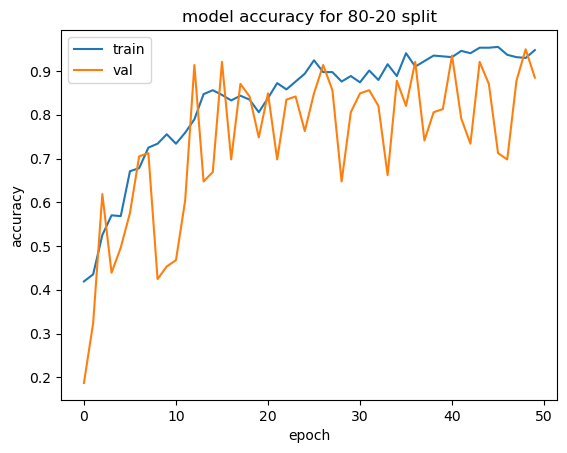

In [57]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy for 80-20 split')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [59]:
import sklearn.metrics

In [75]:
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)

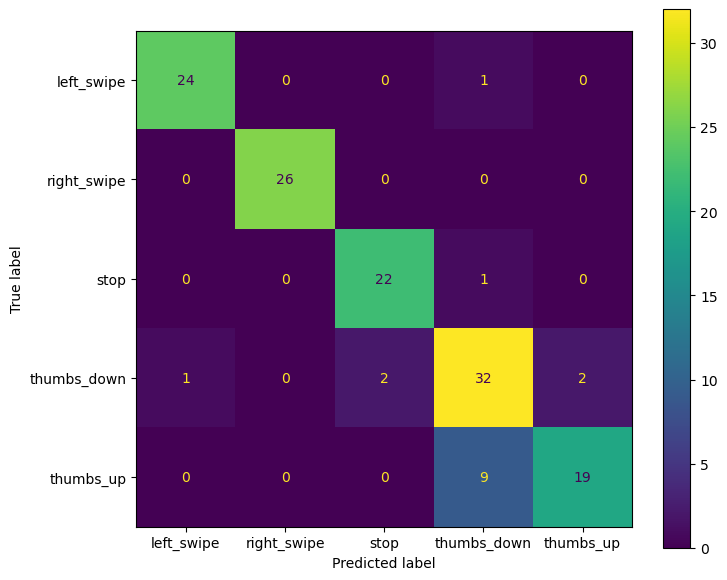

In [83]:
disp = sklearn.metrics.ConfusionMatrixDisplay(cm, display_labels = actions)
fig, ax = plt.subplots(figsize=(8,7))
disp.plot(ax = ax)